### importação das bibliotecas

In [1]:
#  Compatibility imports
from scipy.io import wavfile
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import tensorflow as tf
import scipy.io.wavfile as wav
import numpy as np

from six.moves import xrange as range

try:
    from tensorflow.python.ops import ctc_ops
except ImportError:
    from tensorflow.contrib.ctc import ctc_ops

try:
    from python_speech_features import mfcc
except ImportError:
    print("Failed to import python_speech_features.\n Try pip install python_speech_features.")
    raise ImportError

from utils import maybe_download as maybe_download
from utils import sparse_tuple_from as sparse_tuple_from

In [2]:
# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

In [3]:
# Some configs
num_features = 13
# Accounting the 0th indice +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 50
num_hidden = 50
num_layers = 1
batch_size = 1
initial_learning_rate = 1e-2
momentum = 0.9

num_examples = 1
num_batches_per_epoch = int(num_examples/batch_size)

In [4]:
# Loading the data

#audio_filename = maybe_download('LDC93S1.wav', 93638)
#target_filename = maybe_download('LDC93S1.txt', 62)
#adriano-20101204-fwl/wav/021.wav
audio_filename ='adriano-20101204-fwl//wav//021.wav'
target_filename = 'adriano-20101204-fwl//etc//prompts-original'

fs, audio = wav.read(audio_filename)



#fs, audio = wavfile.read('LDC93S1.wav')

In [5]:
audio.shape

(74000,)

In [6]:
audio

array([258, 457, 425, ..., 679, 747, 884], dtype=int16)

In [7]:
audio[:4]

array([258, 457, 425, 502], dtype=int16)

In [8]:
from pylab import*

In [9]:
timeArray = arange(0, 74000, 1)

In [10]:
plot(timeArray, audio, color='r')
ylabel('Amplitude')
xlabel('Time (ms)')

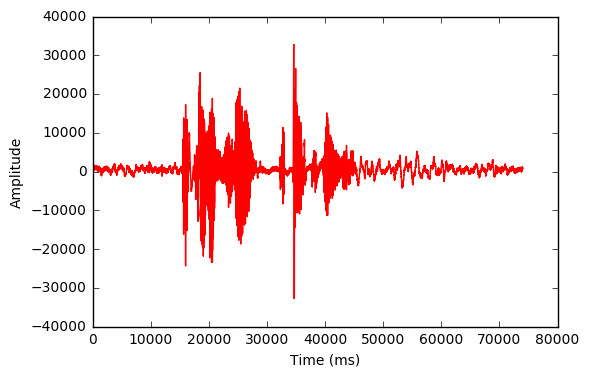

In [11]:
show()

In [12]:
inputs = mfcc(audio, samplerate=fs)

In [13]:
inputs.shape

(461, 13)

In [14]:
inputs[:5]

array([[ 13.5677855 , -10.35944296,  -3.32243799,   1.74942585,
          9.37541404,   8.25916142,  16.06967498,   9.71300626,
          8.91874043,   3.43548826,  15.98592527,   8.89104556,
          5.20070816],
       [ 13.54385676,  -8.65451275,  -2.88884716,   3.03170317,
         10.89117167,   5.68015245,  14.70984483,  13.78639517,
          9.60517981,   4.64967892,  12.69725504,   7.40978536,
         -0.35664742],
       [ 13.43789009,  -8.94075587,  -0.49697284,   5.45430046,
         10.81038286,   6.55344121,   9.95296012,  13.91151892,
         12.63890824,   7.42629994,  13.10748698,   0.68925563,  -4.5541634 ],
       [ 13.44943381,  -8.74811786,  -2.00330375,   5.90604791,
          3.148903  ,   4.44346665,  11.44264258,  14.6638633 ,
         12.37894282,  14.84742645,  12.25751655,   0.34551866,  -0.4389426 ],
       [ 13.09801189,  -8.5498465 ,  -2.1715034 ,   6.1466381 ,
          3.96968661,   7.14780724,  12.98605295,  11.84951285,
         15.06672563,  11.48

In [15]:
# Tranform in 3D array
train_inputs = np.asarray(inputs[np.newaxis, :])

In [16]:
train_inputs.shape

(1, 461, 13)

In [17]:
train_inputs[0]

array([[ 13.5677855 , -10.35944296,  -3.32243799, ...,  15.98592527,
          8.89104556,   5.20070816],
       [ 13.54385676,  -8.65451275,  -2.88884716, ...,  12.69725504,
          7.40978536,  -0.35664742],
       [ 13.43789009,  -8.94075587,  -0.49697284, ...,  13.10748698,
          0.68925563,  -4.5541634 ],
       ..., 
       [ 13.46185144, -12.16881341,  -1.49777472, ...,   2.48138486,
          9.89881231,   8.59124548],
       [ 13.38811425, -11.99425328,  -5.89408932, ...,   9.75816398,
          6.07245495,   5.22508977],
       [ 13.61148257, -11.38483976,  -7.24499278, ...,  12.3133294 ,
          6.49154715,   5.84251601]])

In [21]:
train_inputs = (train_inputs - np.mean(train_inputs))/np.std(train_inputs)

In [22]:
train_inputs.shape

(1, 461, 13)

In [23]:
train_inputs

array([[[ 0.80657345, -1.2255854 , -0.62792688, ...,  1.01194801,
          0.40937415,  0.09595081],
        [ 0.80454116, -1.0807843 , -0.59110166, ...,  0.73263859,
          0.28356952, -0.37603989],
        [ 0.79554133, -1.10509516, -0.38795784, ...,  0.76747992,
         -0.2872105 , -0.73253832],
        ..., 
        [ 0.79757638, -1.3792567 , -0.47295676, ..., -0.13500352,
          0.49496459,  0.38391188],
        [ 0.79131382, -1.36443116, -0.84633931, ...,  0.48301921,
          0.16998897,  0.09802156],
        [ 0.81028468, -1.31267318, -0.96107263, ...,  0.70003148,
          0.20558281,  0.15046007]]])

In [24]:
train_seq_len = [train_inputs.shape[1]]

In [25]:
train_seq_len

[461]

In [26]:
# Readings targets
with open(target_filename, 'r') as f:
    
    #Only the last line is necessary
    #line = f.readlines()[-1]  
    line = f.readlines()[0]  

In [27]:
    line

'021 Aquela mulher é portuguesa. \n'

In [28]:
type(line)

str

In [29]:
s = str(line)

In [30]:
s.strip('\n')

'021 Aquela mulher é portuguesa. '

In [31]:
#original = ' '.join(s.strip().lower().split(' ')[2:]).replace('.', '')
original = 'Aquela mulher e portuguesa vou cumprir'.lower()

In [32]:
original

'aquela mulher e portuguesa vou cumprir'

In [33]:
    original

'aquela mulher e portuguesa vou cumprir'

In [34]:
    targets = original.replace(' ', '  ')
    

In [35]:
    targets

'aquela  mulher  e  portuguesa  vou  cumprir'

In [36]:
    targets = targets.split(' ')

In [37]:
    targets

['aquela', '', 'mulher', '', 'e', '', 'portuguesa', '', 'vou', '', 'cumprir']

In [38]:
# Adding blank label
targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

In [39]:
targets

array(['a', 'q', 'u', 'e', 'l', 'a', '<space>', 'm', 'u', 'l', 'h', 'e',
       'r', '<space>', 'e', '<space>', 'p', 'o', 'r', 't', 'u', 'g', 'u',
       'e', 's', 'a', '<space>', 'v', 'o', 'u', '<space>', 'c', 'u', 'm',
       'p', 'r', 'i', 'r'], 
      dtype='<U7')

In [40]:
# Transform char into index
targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                      for x in targets])

In [41]:
targets

array([ 1, 17, 21,  5, 12,  1,  0, 13, 21, 12,  8,  5, 18,  0,  5,  0, 16,
       15, 18, 20, 21,  7, 21,  5, 19,  1,  0, 22, 15, 21,  0,  3, 21, 13,
       16, 18,  9, 18])

In [42]:
SPACE_TOKEN

'<space>'

In [43]:
SPACE_INDEX

0

In [44]:
FIRST_INDEX

96

In [45]:
# Creating sparse representation to feed the placeholder
train_targets = sparse_tuple_from([targets])

In [46]:
train_targets[0]

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 0, 17],
       [ 0, 18],
       [ 0, 19],
       [ 0, 20],
       [ 0, 21],
       [ 0, 22],
       [ 0, 23],
       [ 0, 24],
       [ 0, 25],
       [ 0, 26],
       [ 0, 27],
       [ 0, 28],
       [ 0, 29],
       [ 0, 30],
       [ 0, 31],
       [ 0, 32],
       [ 0, 33],
       [ 0, 34],
       [ 0, 35],
       [ 0, 36],
       [ 0, 37]])

In [47]:
train_targets[1]

array([ 1, 17, 21,  5, 12,  1,  0, 13, 21, 12,  8,  5, 18,  0,  5,  0, 16,
       15, 18, 20, 21,  7, 21,  5, 19,  1,  0, 22, 15, 21,  0,  3, 21, 13,
       16, 18,  9, 18], dtype=int32)

In [48]:
train_targets[2]

array([ 1, 38])

In [49]:
train_targets

(array([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16],
        [ 0, 17],
        [ 0, 18],
        [ 0, 19],
        [ 0, 20],
        [ 0, 21],
        [ 0, 22],
        [ 0, 23],
        [ 0, 24],
        [ 0, 25],
        [ 0, 26],
        [ 0, 27],
        [ 0, 28],
        [ 0, 29],
        [ 0, 30],
        [ 0, 31],
        [ 0, 32],
        [ 0, 33],
        [ 0, 34],
        [ 0, 35],
        [ 0, 36],
        [ 0, 37]]),
 array([ 1, 17, 21,  5, 12,  1,  0, 13, 21, 12,  8,  5, 18,  0,  5,  0, 16,
        15, 18, 20, 21,  7, 21,  5, 19,  1,  0, 22, 15, 21,  0,  3, 21, 13,
        16, 18,  9, 18], dtype=int32),
 array([ 1, 38]))

In [50]:
# We don't have a validation dataset :(
val_inputs, val_targets, val_seq_len = train_inputs, train_targets, train_seq_len

In [51]:
val_inputs.shape

(1, 461, 13)

In [52]:
train_seq_len

[461]

In [53]:
val_inputs

array([[[ 0.80657345, -1.2255854 , -0.62792688, ...,  1.01194801,
          0.40937415,  0.09595081],
        [ 0.80454116, -1.0807843 , -0.59110166, ...,  0.73263859,
          0.28356952, -0.37603989],
        [ 0.79554133, -1.10509516, -0.38795784, ...,  0.76747992,
         -0.2872105 , -0.73253832],
        ..., 
        [ 0.79757638, -1.3792567 , -0.47295676, ..., -0.13500352,
          0.49496459,  0.38391188],
        [ 0.79131382, -1.36443116, -0.84633931, ...,  0.48301921,
          0.16998897,  0.09802156],
        [ 0.81028468, -1.31267318, -0.96107263, ...,  0.70003148,
          0.20558281,  0.15046007]]])

In [54]:
val_targets

(array([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16],
        [ 0, 17],
        [ 0, 18],
        [ 0, 19],
        [ 0, 20],
        [ 0, 21],
        [ 0, 22],
        [ 0, 23],
        [ 0, 24],
        [ 0, 25],
        [ 0, 26],
        [ 0, 27],
        [ 0, 28],
        [ 0, 29],
        [ 0, 30],
        [ 0, 31],
        [ 0, 32],
        [ 0, 33],
        [ 0, 34],
        [ 0, 35],
        [ 0, 36],
        [ 0, 37]]),
 array([ 1, 17, 21,  5, 12,  1,  0, 13, 21, 12,  8,  5, 18,  0,  5,  0, 16,
        15, 18, 20, 21,  7, 21,  5, 19,  1,  0, 22, 15, 21,  0,  3, 21, 13,
        16, 18,  9, 18], dtype=int32),
 array([ 1, 38]))

In [55]:
val_seq_len

[461]

In [56]:
# THE MAIN CODE!

graph = tf.Graph()

In [57]:
# THE MAIN CODE!

graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell
    cell = tf.nn.rnn_cell.LSTMCell(num_hidden, state_is_tuple=True)

    # Stacking rnn cells
    stack = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers,
                                        state_is_tuple=True)

    # The second output is the last state and we will no use that
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    # Tip: Try another initialization
    # see https://www.tensorflow.org/versions/r0.9/api_docs/python/contrib.layers.html#initializers
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    # Tip: Is tf.zeros_initializer the same?
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = ctc_ops.ctc_loss(logits, targets, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.contrib.ctc.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = ctc_ops.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

In [58]:
inputs

<tf.Tensor 'Placeholder:0' shape=(?, ?, 13) dtype=float32>

In [59]:
targets

In [60]:
chr(70)

'F'

In [61]:
with tf.Session(graph=graph) as session:
    # Initializate the weights and biases
    tf.initialize_all_variables().run()


    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch):

            feed = {inputs: train_inputs,
                    targets: train_targets,
                    seq_len: train_seq_len}

            batch_cost, _ = session.run([cost, optimizer], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size

        train_cost /= num_examples
        train_ler /= num_examples

        val_feed = {inputs: val_inputs,
                    targets: val_targets,
                    seq_len: val_seq_len}

        val_cost, val_ler = session.run([cost, ler], feed_dict=val_feed)

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler,
                         val_cost, val_ler, time.time() - start))
    # Decoding
    d = session.run(decoded[0], feed_dict=feed)
    str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
    # Replacing blank label to none
    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

    print('Original:\n%s' % original)
    print('Decoded:\n%s' % str_decoded)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1/50, train_cost = 1309.874, train_ler = 0.895, val_cost = 435.224, val_ler = 0.895, time = 0.866
Epoch 2/50, train_cost = 435.224, train_ler = 1.000, val_cost = 689.978, val_ler = 1.000, time = 0.326
Epoch 3/50, train_cost = 689.978, train_ler = 0.895, val_cost = 300.123, val_ler = 0.895, time = 0.343
Epoch 4/50, train_cost = 300.123, train_ler = 0.895, val_cost = 196.641, val_ler = 0.895, time = 0.351
Epoch 5/50, train_cost = 196.641, train_ler = 0.842, val_cost = 170.139, val_ler = 0.842, time = 0.359
Epoch 6/50, train_cost = 170.139, train_ler = 0.895, val_cost = 150.922, val_ler = 0.895, time = 0.398
Epoch 7/50, train_cost = 150.922, train_ler = 0.895, val_cost = 145.539, val_ler = 0.895, time = 0.452
Epoch 8/50, train_cost = 145.539, train_ler = 0.895, val_cost = 132.099, val_ler = 0.895, time = 0.378
Epoch 9/50, train_cost = 132.099, train_ler = 0.868, val_cost = 127.402, val_ler = 0.868, time = 0.36